In [1]:
# Basic RL structures refers to https://colab.research.google.com/github/Cheukting/rl_workshop/blob/master/exercises/rl_workshop_dqn.ipynb
#!git clone https://github.com/James-LLJ/gym
!git clone https://github.com/James-LLJ/Atari-Alien-v0

Cloning into 'Atari-Alien-v0'...
remote: Enumerating objects: 10900, done.
remote: Counting objects: 100% (10900/10900), done.
remote: Compressing objects: 100% (2788/2788), done.
remote: Total 10900 (delta 7957), reused 10880 (delta 7947), pack-reused 0
Receiving objects: 100% (10900/10900), 3.05 MiB | 17.54 MiB/s, done.
Resolving deltas: 100% (7957/7957), done.


In [ ]:
%cd ./Atari-Alien-v0
!pip install -e.

/content/Atari-Alien-v0
Obtaining file:///content/Atari-Alien-v0
  Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3
  Running setup.py develop for gym


In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow.compat.v1 as tf
import numpy as np
import pandas as pd
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import os
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

from __future__ import absolute_import, division, print_function
from tensorflow import keras

import csv
from google.colab import files

## Task 1: Processing game image 

Raw atari images are large, 210x160x3 by default. However, we don't need that level of detail in order to learn them.

We can thus save a lot of time by preprocessing game image, including
* Resizing to a smaller shape, 64 x 64
* Converting to grayscale
* Cropping irrelevant image parts (top & bottom)

In [ ]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [ ]:
from gym.core import ObservationWrapper
from gym.spaces import Box
import skimage

#from scipy.misc import imresize
from skimage import color
from skimage import transform

class PreprocessAtari(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and optionally grayscales it."""
        ObservationWrapper.__init__(self,env)
        
        self.img_size = (64, 64)
        self.observation_space = Box(0.0, 1.0, shape=(self.img_size[0], self.img_size[1], 1))

    def observation(self, img):
        """what happens to each observation"""
        
        # Here's what you need to do:
        #  * crop image, remove irrelevant parts
        #  * resize image to self.img_size 
        #     (use imresize imported above or any library you want,
        #      e.g. opencv, skimage, PIL, keras)
        #  * cast image to grayscale
        #  * convert image pixels to (0,1) range, float32 type

        top = 10
        bottom = len(img)-40
        left = 5
        right = len(img[1])-5
        crop_img = img[top:bottom, left:right, :]
        #print(top, bottom, left, right)

        img2 = skimage.transform.resize(crop_img, self.img_size)
        img2 = color.rgb2gray(img2)
        s = (img2.shape[0], img2.shape[1], 1 )
        img2 = img2.reshape(s)
        img2 = img2.astype('float32') / img2.max()
        return img2
  


In [ ]:
#spawn game instance for tests
env = gym.make("Alien-v0")
#env = PreprocessAtari(env)

# Run MsPacman-v0 for testing
# env = gym.make("MsPacman-v0")


observation_shape = env.observation_space.shape
#n_actions = env.action_space.n
n_actions = 9

obs = env.reset()
print(obs.shape)
print(n_actions)

#test observation
assert obs.ndim == 3, "observation must be [batch, time, channels] even if there's just one channel"
assert obs.shape == observation_shape
#assert obs.dtype == 'float32'
#assert len(np.unique(obs))>2, "your image must not be binary"
#assert 0 <= np.min(obs) and np.max(obs) <=1, "convert image pixels to (0,1) range"

print("Formal tests seem fine. Here's an example of what you'll get.")

plt.title("what your network gonna see")
plt.imshow(obs[:, :, 0], interpolation='none');


ModuleNotFoundError: ignored

## Frame buffer

Our agent can only process one observation at a time, so we gotta make sure it contains enough information to find optimal actions. For instance, agent has to react to moving objects so he must be able to measure object's velocity.

To do so, we introduce a buffer that stores 8 last images. This time everything is pre-implemented for you.

In [ ]:
from gym.core import Wrapper
class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=8, dim_order='tensorflow'):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(FrameBuffer, self).__init__(env)
        self.dim_order = dim_order
        if dim_order == 'tensorflow':
            height, width, n_channels = env.observation_space.shape # h=64, width=64, channels=1
            obs_shape = [height, width, n_channels * n_frames]
        elif dim_order == 'pytorch':
            n_channels, height, width = env.observation_space.shape
            obs_shape = [n_channels * n_frames, height, width]
        else:
            raise ValueError('dim_order should be "tensorflow" or "pytorch", got {}'.format(dim_order))
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')
        
    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer
    
    def step(self, action):
        """plays breakout for 1 step, returns frame buffer"""
        minAlien, minDist, new_img, score, reward, done, info = self.env.step(action)
        self.update_buffer(new_img)
        return  minAlien, minDist, self.framebuffer, score, reward, done, info
    
    def update_buffer(self, img):
        if self.dim_order == 'tensorflow':
            offset = self.env.observation_space.shape[-1]
            axis = -1
            cropped_framebuffer = self.framebuffer[:,:,:-offset]
        elif self.dim_order == 'pytorch':
            offset = self.env.observation_space.shape[0]
            axis = 0
            cropped_framebuffer = self.framebuffer[:-offset]
        self.framebuffer = np.concatenate([img, cropped_framebuffer], axis = axis)


In [ ]:
def make_env():
    env = gym.make("Alien-v0")
    #env = gym.make("MsPacman-v0")
  
    #env = PreprocessAtari(env)
    env = FrameBuffer(env, n_frames=4, dim_order='tensorflow')
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

## Task 2: Building a network

We now need to build a neural network that can map images to state q-values. This network will be called on every agent's step so it better not be resnet-152 unless you have an array of GPUs. Instead, you can use strided convolutions with a small number of features to save time and memory.

You can build any architecture you want, but for reference, here's something that will more or less work:

![img](https://github.com/shenweichen/Coursera/blob/master/Specialization_Advanced_Machine_Learning_Higher_School_of_Economics/Course4_Practical%20Reinforcement%20Learning/week4_approx/img/cnn.png?raw=1)

In [ ]:
try:
    sess.close()
except:
    pass

tf.reset_default_graph()
sess = tf.InteractiveSession()

In [ ]:
from keras.layers import Conv2D, Dense, Flatten
from keras.models import Sequential
tf.compat.v1.disable_eager_execution()

# Define a variable for epsilon of each step. epsilon_display will be displayed every epsidode
epsilon_display = 0

class DQNAgent:
    def __init__(self, name, state_shape, n_actions, epsilon=0, reuse=False, Eps_start=1.0000, Eps_end=0.100, Eps_decay=0.9971):
        """A simple DQN agent"""
        with tf.compat.v1.variable_scope(name, reuse=reuse):
            
            #< Define your network body here. Please make sure you don't use any layers created elsewhere >
            self.network = Sequential()
            self.network.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(2, 2), activation='relu'))
            self.network.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), activation='relu'))
            self.network.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), activation='relu'))
            self.network.add(Flatten())
            self.network.add(Dense(256, activation='relu'))
            self.network.add(Dense(n_actions, activation='linear'))
            
            # prepare a graph for agent step            
            self.state_t = tf.placeholder('float32', [None,] + list(state_shape),name='self.state_t')
            self.qvalues_t = self.get_symbolic_qvalues(self.state_t)
            
        self.weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=name)
        self.Eps_start = Eps_start
        self.Eps_end = Eps_end
        self.Eps_decay = Eps_decay

    def get_symbolic_qvalues(self, state_t):
        """takes agent's observation, returns qvalues. Both are tf Tensors"""
       
        qvalues = self.network(state_t) #< symbolic tensor for q-values >
        
        assert tf.is_numeric_tensor(qvalues) and qvalues.shape.ndims == 2, \
            "please return 2d tf tensor of qvalues [you got %s]" % repr(qvalues)
        assert int(qvalues.shape[1]) == n_actions
        
        return qvalues
    
    def get_qvalues(self, state_t):
        """Same as symbolic step except it operates on numpy arrays"""
        sess = tf.get_default_session()
        return sess.run(self.qvalues_t, {self.state_t: state_t})
    
    def sample_actions(self, qvalues, episode):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)

        self.explore_epis = 1400  # Agent only explores for 'explore_epis' episodes

        self.Eps_decay_exp = (self.Eps_end / self.Eps_start)**(1/self.explore_epis)
        epsilon = max(self.Eps_end, round(self.Eps_start * self.Eps_decay_exp**episode, 4)) # Exponential decay
        # self.Eps_decay_lin = (self.Eps_start - self.Eps_end)/self.explore_epis
        # epsilon =  max(self.Eps_end, round(self.Eps_start - episode*self.Eps_decay_lin, 4)) # Linear decay based on episode  

        should_explore = np.random.choice([0, 1], batch_size, p = [1-epsilon, epsilon]) # 1 for random action and 0 for best action
        return np.where(should_explore, random_actions, best_actions)[0], epsilon # More 1 in should_explore, more exploitation and tend to choose best_actions


In [ ]:
epsilon_linear_arr = []
epi_explore = 100
for episode in range(150):
    epsilon = max(0.1, 1 - (1 - 0.1)/epi_explore * episode)
    epsilon_linear_arr.append(round(epsilon,4))

print(epsilon_linear_arr)

epsilon_expo_arr = []
eps_explore_expo = 100
for episode in range(150):
    eps_decay = (0.1/1)**(1/eps_explore_expo)
    epsilon = max(0.1, 1 * eps_decay**episode)
    epsilon_expo_arr.append(round(epsilon,4))

print(epsilon_expo_arr)

plt.plot(epsilon_linear_arr)
plt.plot(epsilon_expo_arr)

In [ ]:
agent = DQNAgent("dqn_agent", state_dim, n_actions)
sess.run(tf.global_variables_initializer())

Now let's try out our agent to see if it raises any errors.

In [ ]:
def evaluate(env, agent, n_games, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    gameScores = []

    for episode in range(n_games):
        s = env.reset()
        reward = 0
        gameScore = 0
        epsilon = None

        for step in range(t_max):  
            qvalues = agent.get_qvalues([s])
            action, epsilon = (qvalues.argmax(axis=-1)[0], 0) if greedy else agent.sample_actions(qvalues, 900)
            _, _, _, score, r, done, _ = env.step(action)
            gameScore += score
            reward += r
            if done: break

        rewards.append(reward)
        gameScores.append(gameScore)
        print("At Episode ", episode, ", Game Score is ", gameScore, ", emotional model Reward is ", reward)    
    
    plt.subplot(2,1,1)
    plt.title("Evaluated Emotional Model Rewards")
    plt.ylabel("Rewards")
    plt.xlabel("Episode")
    plt.plot(rewards)
    plt.grid()
    print("\n\n\n")
    plt.show()

    plt.subplot(2,1,2)
    plt.title("Evaluated Game Scores")
    plt.ylabel("Game Scores")
    plt.xlabel("Episode")
    plt.plot(gameScores)
    plt.grid()
    plt.show()
    

    return rewards, gameScores

## Experience replay
You are also provided with experience replay buffer as follows.

![img](https://github.com/shenweichen/Coursera/blob/master/Specialization_Advanced_Machine_Learning_Higher_School_of_Economics/Course4_Practical%20Reinforcement%20Learning/week4_approx/img/exp_rep.png?raw=1)

#### The interface is fairly simple:
* `exp_replay.add(obs, act, rw, next_obs, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns observations, actions, rewards, next_observations and is_done for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.

In [ ]:
import numpy as np
import random

class ReplayBuffer(object):
    def __init__(self, size):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows, the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        data = (obs_t, action, reward, obs_tp1, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.array(obs_t, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False))
            dones.append(done)
        return np.array(obses_t), np.array(actions), np.array(rewards), np.array(obses_tp1), np.array(dones)

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
        return self._encode_sample(idxes)


## Let's play the game!

In [ ]:

def play_and_record(agent, env, exp_replay, n_steps, episode, train_step=None, td_loss=None):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer. 
    Whenever game ends, add record with done=True and reset the game.
    :returns: return sum of rewards over time
    
    Note: please do not env.reset() unless env is done.
    It is guaranteed that env has done=False when passed to this function.
    """

    minAlien_arr = []
    minDist_arr = []

    # State at the beginning of rollout
    s = env.framebuffer
    
    # Play the game for n_steps as per instructions above
    reward = 0
    epsilon = None
    num_step = 0
    score_per_epi = 0

    for t in range(n_steps):
        qvalues = agent.get_qvalues([s])
        action, epsilon = agent.sample_actions(qvalues, episode)
        minAlien, minDist, next_s, score, r, done, _ = env.step(action)
        # exp_replay.add(s, action, score, next_s, done)  # Change this line to train agent with game score / EM reward

        # To nomalised the score and reward by converting them to ratio repectively to total score and total reward
        nomalised_score = score / 1000
        nomalised_reward = r / 2000
        exp_replay.add(s, action, ( (0.5*nomalised_score + 0.5*nomalised_reward) / (1000+2000) ) * 100, next_s, done)  # Train agent with a combination of game score and EM reward

        score_per_epi += score
        reward += r        

        if minAlien < 1000:
            minAlien_arr.append(minAlien)
        if minDist < 1000:    
            minDist_arr.append(minDist)

        # train
        if (train_step is not None and (t+1) % 4 == 0):  # Change the frequency of sample batch from RM and train 
            _, loss_t = sess.run([train_step, td_loss], sample_batch(exp_replay, batch_size=16))
            td_loss_history.append(loss_t)  
        

        if done: 
            s = env.reset() 
            num_step = t
            #print("DEAD!!", "Reward is:  ", reward, "   Epsilon is:  ", epsilon_display)
            break
        else:
            s = next_s
        
    return reward, epsilon, num_step, np.mean(minAlien_arr[:]), np.mean(minDist_arr[:]), score_per_epi

### Target networks

We also employ the so called "target network" - a copy of neural network weights to be used for reference Q-values:

The network itself is an exact copy of agent network, but it's parameters are not trained. Instead, they are moved here from agent's actual network every so often.

$$ Q_{reference}(s,a) = r + \gamma \cdot \max _{a'} Q_{target}(s',a') $$

![img](https://github.com/shenweichen/Coursera/blob/master/Specialization_Advanced_Machine_Learning_Higher_School_of_Economics/Course4_Practical%20Reinforcement%20Learning/week4_approx/img/target.png?raw=1)



In [ ]:
target_network = DQNAgent("target_network", state_dim, n_actions)

In [ ]:
def load_weigths_into_target_network(agent, target_network):
    """ assign target_network.weights variables to their respective agent.weights values. """
    assigns = []
    for w_agent, w_target in zip(agent.weights, target_network.weights):
        assigns.append(tf.assign(w_target, w_agent, validate_shape=True))
    tf.get_default_session().run(assigns)

### Learning with... Q-learning
Here we write a function similar to `agent.update` from tabular Q-learning (last exercise). 

In [ ]:
# placeholders that will be fed with exp_replay.sample(batch_size)
obs_ph = tf.placeholder(tf.float32, shape=(None,) + state_dim,name='obs')
actions_ph = tf.placeholder(tf.int32, shape=[None],name='actions')
rewards_ph = tf.placeholder(tf.float32, shape=[None],name='rewards')
next_obs_ph = tf.placeholder(tf.float32, shape=(None,) + state_dim,name='next_obs')
is_done_ph = tf.placeholder(tf.float32, shape=[None],name='is_done')

is_not_done = 1 - is_done_ph
gamma = 0.99

Take q-values for actions agent just took

In [ ]:
current_qvalues = agent.get_symbolic_qvalues(obs_ph)
current_action_qvalues = tf.reduce_sum(tf.one_hot(actions_ph, n_actions) * current_qvalues, axis=1)

Compute Q-learning TD error:

$$ L = { 1 \over N} \sum_i [ Q_{\theta}(s,a) - Q_{reference}(s,a) ] ^2 $$

With Q-reference defined as

$$ Q_{reference}(s,a) = r(s,a) + \gamma \cdot max_{a'} Q_{target}(s', a') $$

Where
* $Q_{target}(s',a')$ denotes q-value of next state and next action predicted by __target_network__
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.

In [ ]:
# compute q-values for NEXT states with target network
next_qvalues_target = target_network.get_symbolic_qvalues(next_obs_ph)

# compute state values by taking max over next_qvalues_target for all actions
next_state_values_target =  is_not_done * tf.reduce_max(next_qvalues_target,axis=1)

# compute Q_reference(s,a) as per formula above.
reference_qvalues = rewards_ph +   gamma * next_state_values_target

# Define loss function for sgd.
td_loss = (current_action_qvalues - reference_qvalues) ** 2
td_loss = tf.reduce_mean(td_loss)

train_step = tf.train.AdamOptimizer(1e-3).minimize(td_loss, var_list=agent.weights)

In [ ]:
sess.run(tf.global_variables_initializer())

### Main loop

It's time to put everything together and see if it learns anything. Training anything meaningful will take a long time. **It may even be too long for the Colab runtime even with the GPU.** We will cut the training short in this exercise just to demonstrate the idea.

In [ ]:
from tqdm import trange
from IPython.display import clear_output
#from pandas import ewma
#import pandas as pd
%matplotlib inline

plt.rcParams["figure.figsize"] = (8, 16)

mean_rw_history = []
td_loss_history = []

In [ ]:
exp_replay = ReplayBuffer(10000)

def sample_batch(exp_replay, batch_size):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(batch_size)
    return {
        obs_ph:obs_batch, actions_ph:act_batch, rewards_ph:reward_batch, 
        next_obs_ph:next_obs_batch, is_done_ph:is_done_batch
    }

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")


Mounted at /content/gdrive


In [ ]:
# !pip install pandas
import pandas as pd
pd.read_csv('/content/gdrive/My Drive/Colab Notebooks_Linjun/Alien Pure Score.csv')

,Episode,Epsilon,Step,GameScore,Reward,MinAlien,MinDist
0,0,1.0000,519,110,-143,53.975521,10.834721
1,1,0.9977,607,187,-238,51.090585,15.861236
2,2,0.9954,422,169,-9,53.703026,12.698580
3,3,0.9931,416,183,0,52.216434,13.555244
4,4,0.9908,640,197,73,47.919589,16.229502
...,...,...,...,...,...,...,...
146,146,0.6642,607,480,1402,51.090585,15.861236
147,147,0.6619,422,624,1500,53.703026,12.698580
148,148,0.6596,416,537,943,52.216434,13.555244
149,149,0.6573,640,562,1053,47.919589,16.229502


In [ ]:
# Create a function to save checkpoints and a function to load checkpoints from Google Drive

def save_checkpoint():
    agent.network.save('/content/gdrive/My Drive/Colab Notebooks_Linjun/Agent network_0.5to0.5_nomalised')
    target_network.network.save('/content/gdrive/My Drive/Colab Notebooks_Linjun/Target network_0.5to0.5_nomalised')
    agent.network.summary()
    target_network.network.summary()

def load_checkpoint():
    global agent, target_network
    agent.network = keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks_Linjun/Agent network_0.5to0.5_nomalised', compile=False)  
    target_network.target_network = keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks_Linjun/Target network_0.5to0.5_nomalised', compile=False)
    agent.network.summary()
    target_network.network.summary()


In [ ]:
# Set a Boolean value to check if we need to load models from Google Drive

#check_load_model = False
#check_load_model = True
check_load_model = None

In [ ]:
episode_array = []
epsilon_array = []
num_steps = []
rewards = []
gamescores = []
minAlien_arr = []
minDist_arr = []

In [ ]:
if check_load_model == False:
       
    for episode in range(1500):
        # play
        reward, epsilon, steps, minAlien_per_epi, minDist_per_epi, score = play_and_record(agent, env, exp_replay, n_steps=10000,
                                                episode=episode, train_step=train_step, td_loss=td_loss)
        print("Alien Distance:  ", minAlien_per_epi, "; Egg Distance:  ", minDist_per_epi)
        # Store epsilon, scores and steps of each episode in epsilon_array
        epsilon_array.append(epsilon)
        num_steps.append(steps)
        rewards.append(reward)
        gamescores.append(score)
        minAlien_arr.append(minAlien_per_epi)
        minDist_arr.append(minDist_per_epi)
        
        # Create a CSV file to save output values. Save it and save training models every 10 episode. 
        fileName = '/content/gdrive/My Drive/Colab Notebooks_Linjun/0.5 Score+0.5 Reward_nomalised.csv'

        if episode % 5 == 0:
            save_checkpoint()

            with open(fileName, mode='w') as csv_file:
                fieldnames = ['Episode', 'Epsilon', 'Step', 'GameScore', 'Reward', 'MinAlien', 'MinDist']
                writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
                writer.writeheader()

                for i in range(episode):
                    writer.writerow({'Episode': i, 'Epsilon': epsilon_array[i],
                                    'Step': num_steps[i], 'GameScore': gamescores[i], 'Reward': rewards[i], 
                                     'MinAlien': minAlien_arr[i], 'MinDist': minDist_arr[i]})

        # Adjust agent parameters by loading policy network into target network
        if episode % 30 == 0 and episode != 0:
            load_weigths_into_target_network(agent, target_network)
            print("Load nerual network weights from Policy Network to Target Nework")

            if np.mean(gamescores[-10:]) > 800:
                print('Should be ok')
                break
                
        print("episode = %i, buffer size = %i, epsilon = %.5f" % (episode, len(exp_replay), epsilon))
        clear_output(wait=True)


Column names are Episode, Epsilon, Step, GameScore, Reward, MinAlien, MinDist






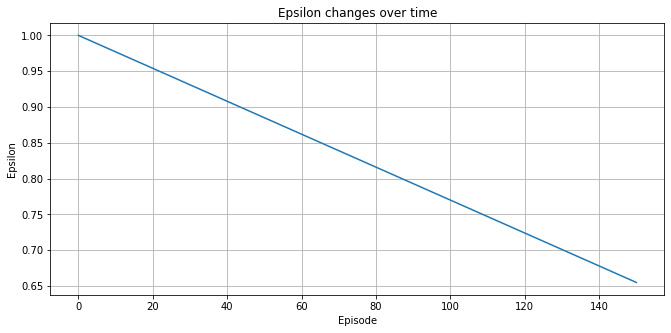

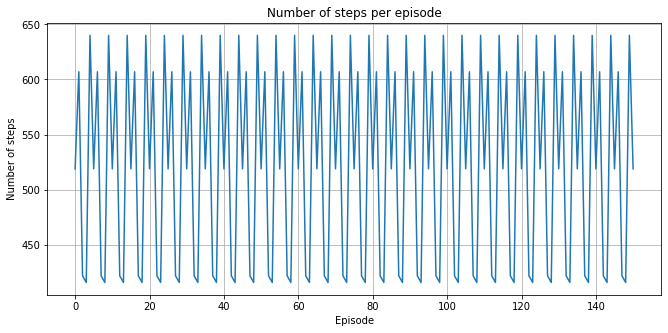

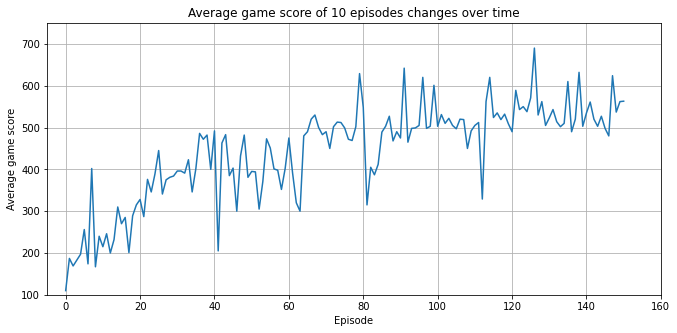

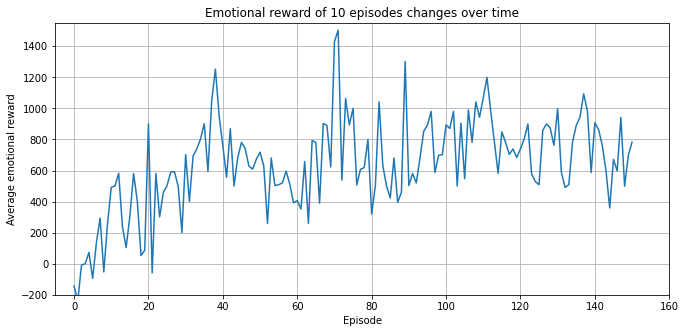

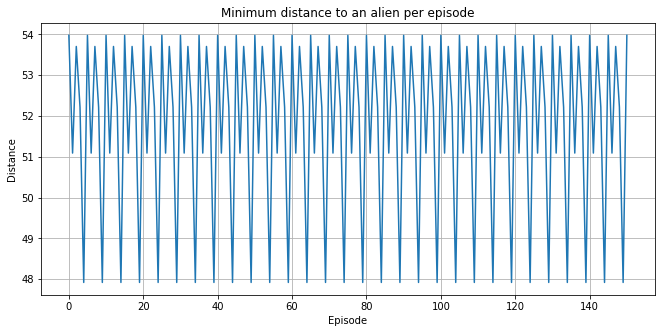

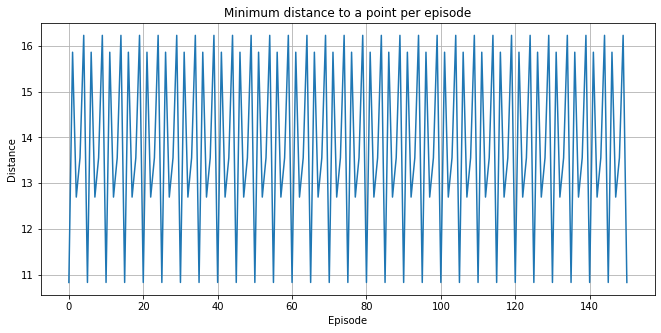

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


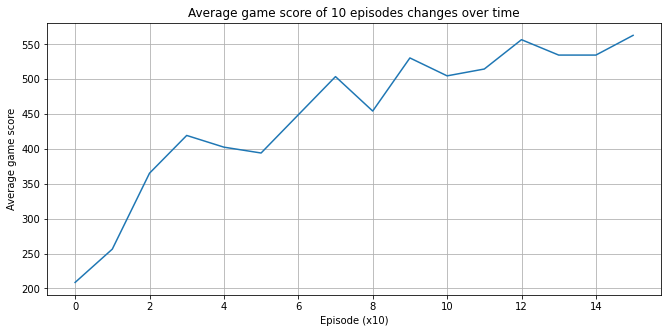

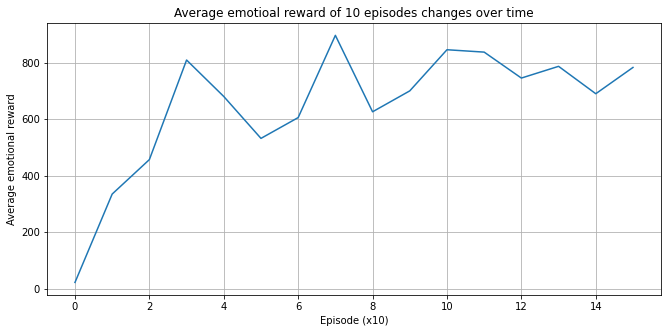

In [ ]:
# Create a function to load and draw saved values
def load_and_draw(): 

    temp_episode = []
    temp_epsilon = []
    temp_step = []
    temp_score = []
    temp_reward = []
    temp_minAlien = []
    temp_minDist = []

    score_avg = []
    reward_avg = []

    with open('/content/gdrive/My Drive/Colab Notebooks_Linjun/Alien Pure Reward.csv', mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        line_count = 0 

        for row in csv_reader:
            if line_count == 0:
                print(f'Column names are {", ".join(row)}')
                line_count += 1
                
            # print(f'Episode is {row["Epsilon"]}, Step is {row["Steps"]}, and Score is {row["Game_scores"]}.')

            line_count += 1
            temp_episode.append(int(row['Episode']))
            temp_epsilon.append(float(row['Epsilon']))
            temp_step.append(int(row['Step']))
            temp_score.append(float(row['GameScore']))
            temp_reward.append(float(row['Reward']))
            temp_minAlien.append(float(row['MinAlien']))
            temp_minDist.append(float(row['MinDist']))

    plt.figure(figsize=(11, 5))
    #plt.subplot(4,1,1)
    plt.title("Epsilon changes over time")
    plt.ylabel("Epsilon")
    plt.xlabel("Episode")
    plt.plot(temp_episode, temp_epsilon)
    plt.grid()
    print("\n\n\n")
    plt.show()

    plt.figure(figsize=(11, 5))
    # Plot trend of number of steps
    #plt.subplot(4,1,2)
    plt.title("Number of steps per episode")
    plt.ylabel("Number of steps")
    plt.xlabel("Episode")
    plt.plot(temp_episode, temp_step)
    plt.grid()
    print("\n\n\n")
    plt.show()

    plt.figure(figsize=(11, 5))
    plt.xlim([-5, 160])
    plt.ylim([100, 750])
    # Plot trend of gamescore
    #plt.subplot(4,1,3)
    plt.title('Average game score of 10 episodes changes over time')
    plt.ylabel("Average game score")
    plt.xlabel("Episode")
    plt.plot(temp_episode, temp_score)
    plt.grid()
    print("\n\n\n")
    plt.show()

    plt.figure(figsize=(11, 5))
    plt.xlim([-5, 160])
    plt.ylim([-200, 1550])
    # Plot trend of emotional reward
    #plt.subplot(4,1,4)
    plt.title('Emotional reward of 10 episodes changes over time')
    plt.ylabel("Average emotional reward")
    plt.xlabel("Episode")
    plt.plot(temp_episode, temp_reward)
    plt.grid()
    print("\n\n\n")
    plt.show()

    plt.figure(figsize=(11, 5))
    # Plot trend of minimum distance to an alien 
    #plt.subplot(4,1,1)
    plt.title('Minimum distance to an alien per episode')
    plt.ylabel("Distance")
    plt.xlabel("Episode")
    plt.plot(temp_episode, temp_minAlien)
    plt.grid()
    print("\n\n\n")
    plt.show()

    plt.figure(figsize=(11, 5))
    # Plot trend of minimum distance to a point
    #plt.subplot(4,1,2)
    plt.title('Minimum distance to a point per episode')
    plt.ylabel("Distance")
    plt.xlabel("Episode")
    plt.plot(temp_episode, temp_minDist)
    plt.grid()
    print("\n\n\n")
    plt.show()

    for n in range(len(temp_score)-10):
        score_avg.append(np.mean(temp_score[10*n: 10*n+10]))
        reward_avg.append(np.mean(temp_reward[10*n: 10*n+10]))

    plt.figure(figsize=(11, 5))
    #plt.subplot(4,1,3)
    plt.title('Average game score of 10 episodes changes over time')
    plt.ylabel("Average game score")
    plt.xlabel("Episode (x10)")
    plt.plot(score_avg)
    plt.grid()
    print("\n\n\n")
    plt.show()

    plt.figure(figsize=(11, 5))
    #plt.subplot(4,1,4)
    plt.title('Average emotioal reward of 10 episodes changes over time')
    plt.ylabel("Average emotional reward")
    plt.xlabel("Episode (x10)")
    plt.plot(reward_avg)
    plt.grid()
    print("\n\n\n")
    plt.show()

    # Clarify the lists are global list before modify them
    global episode_array, epsilon_array, num_steps, rewards, gamescores, minAlien_arr, minDist_arr

    episode_array = np.zeros(len(temp_epsilon))
    episode_array = temp_episode[:]
    epsilon_array = np.zeros(len(temp_epsilon))
    epsilon_array = temp_epsilon[:]
    num_steps = np.zeros(len(temp_epsilon))
    num_steps = temp_step[:]
    rewards = np.zeros(len(temp_epsilon))
    rewards = temp_reward[:]
    gamescores = np.zeros(len(temp_epsilon))
    gamescores = temp_score[:]
    minAlien_arr = np.zeros(len(temp_epsilon))
    minAlien_arr = temp_minAlien[:]
    minDist_arr = np.zeros(len(temp_epsilon))
    minDist_arr = temp_minDist[:]

load_and_draw()


In [ ]:
if check_load_model == True:
  
    load_checkpoint()
    load_and_draw()

    for episode in range(episode_array[-1]+1, 1500):
        # play
        reward, epsilon, steps, minAlien_per_epi, minDist_per_epi, score = play_and_record(agent, env, exp_replay, n_steps=10000,
                                                episode=episode, train_step=train_step, td_loss=td_loss)
        print("Alien Distance:  ", minAlien_per_epi, "; Egg Distance:  ", minDist_per_epi)
        # Store epsilon, scores and steps of each episode in epsilon_array
        epsilon_array.append(epsilon)
        num_steps.append(steps)
        rewards.append(reward)
        gamescores.append(score)
        minAlien_arr.append(minAlien_per_epi)
        minDist_arr.append(minDist_per_epi)
        
        # Create a CSV file to save output values. Save it and save training models every 10 episode. 
        fileName = '/content/gdrive/My Drive/Colab Notebooks_Linjun/0.5 Score+0.5 Reward_nomalised.csv'

        if episode % 5 == 0 or episode == 1499:
            save_checkpoint()

            with open(fileName, mode='w') as csv_file:
                fieldnames = ['Episode', 'Epsilon', 'Step', 'GameScore', 'Reward', 'MinAlien', 'MinDist']
                writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
                writer.writeheader()

                for i in range(episode):
                    writer.writerow({'Episode': i, 'Epsilon': epsilon_array[i],
                                    'Step': num_steps[i], 'GameScore': gamescores[i], 'Reward': rewards[i], 
                                     'MinAlien': minAlien_arr[i], 'MinDist': minDist_arr[i]})

        # Adjust agent parameters by loading policy network into target network
        if episode % 30 == 0 and episode != 0:
            load_weigths_into_target_network(agent, target_network)
            print("Load nerual network weights from Policy Network to Target Nework")

            if np.mean(gamescores[-10:]) > 800:
                print('Should be ok')
                break
                
        print("episode = %i, buffer size = %i, epsilon = %.5f" % (episode, len(exp_replay), epsilon))
        print("game score: ", score, "  emotional reward: ", reward)
        clear_output(wait=True)


Column names are Episode, Epsilon, Step, GameScore, Reward, MinAlien, MinDist






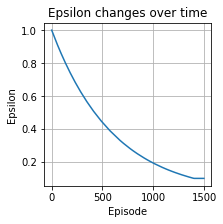

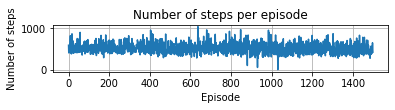

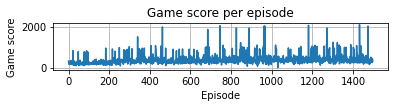

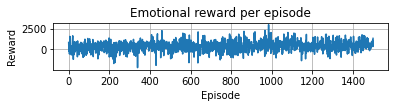

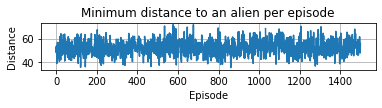

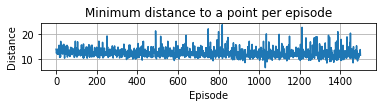

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


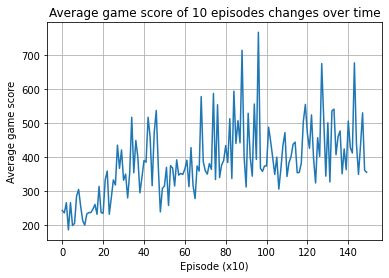

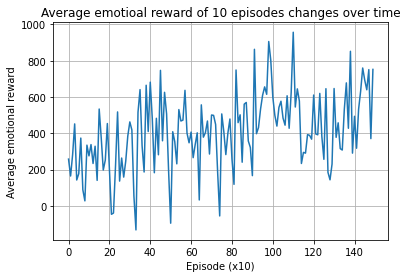

In [ ]:
# Load and draw information from load models and saved .CSV file
load_and_draw()

# Evaluate the training result (Deliberately put down a wrong punctuation ';' to pause the program)

#evaluate(make_env(), agent, n_games=100, greedy=False);

### Make A Video

In [ ]:
agent.epsilon=0 # To reset epsilon back to previous value if you want to go on training

In [ ]:
#!pip install 'imageio==2.4.0'

In [ ]:
import IPython

def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [ ]:
import imageio
from skimage import img_as_ubyte, img_as_float

# Redefine evaluate class returning only four outputs. Do this for generating a video
def evaluate_video(env, agent, n_games, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """

    filename = "/content/gdrive/My Drive/Colab Notebooks_Linjun/Alien_v0" + ".mp4"

    with imageio.get_writer(filename, fps=60) as video:
        for n in range(n_games):
            gameScore = 0
            reward = 0

            while gameScore < 400:
                gameScore = 0
                reward = 0

                s = env.reset()
                temp_video_data = []

                for step in range(t_max):  
                    qvalues = agent.get_qvalues([s])
                    action, epsilon = (qvalues.argmax(axis=-1)[0], 0) if greedy else agent.sample_actions(qvalues, 1000)
                    _, _, s, score, r, done, _ = env.step(action)
                    gameScore += score
                    reward += r

                    render_img = env.render(mode='rgb_array')  
                    red_layer = render_img[:, :, 0]
                    green_layer = render_img[:, :, 1]
                    blue_layer = render_img[:, :, 2]

                    temp_memory = np.zeros((210, 160, 3))
                    temp_memory[:, :, 0] = red_layer 
                    temp_memory[:, :, 1] = green_layer 
                    temp_memory[:, :, 2] = blue_layer

                    # Convert data type of elements in the array from float64 to unit8
                    temp_memory = img_as_ubyte(temp_memory/255)

                    temp_video_data.append(temp_memory)

                    #video.append_data(render_img)
                    #video_temp.append_data(temp_memory)

                    if done: 
                        for i in range(100):
                            temp_video_data.append(temp_memory)  # To freeze the screen on the last slide
      
                        print("Game score: ", gameScore, "   Reward: ", reward)
                        break

            if gameScore >= 400:
                for index in range(len(temp_video_data)):
                    video.append_data(temp_video_data[index])

    return embed_mp4(filename)

   

# Generate a recorded video
evaluate_video(make_env(), agent, n_games=5, greedy=False)
